In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from libs.pconv_model import PConvUnet
from libs.util import ImageChunker, MaskGenerator
import matplotlib.image as mpimg
import cv2
from matplotlib import cm
from mpl_toolkits import mplot3d
import tensorflow as tf
import itertools
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle


os.environ["CUDA_VISIBLE_DEVICES"] = "5"

def plot_pred(_pred, _mask, _orig):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(_orig * _mask)
    axes[1].imshow(_pred)
    axes[2].imshow(_orig)
    axes[0].set_title('Masked Image')
    axes[1].set_title('Predicted Image')
    axes[2].set_title('Original Image')


def heatmap2d(x, y, z, _orig=None, fname=None):
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    if _orig is None:
        fig, ax = plt.subplots()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('')
        ax.axis([x.min(), x.max(), y.min(), y.max()])
        fig.colorbar(c, ax=ax)
    else:
        _, axes = plt.subplots(1, 2, figsize=(20, 8))
        axes[0].imshow(_orig)
        axes[0].set_title('Original Image')
        c = axes[1].pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        axes[1].set_title('Diff. map')
        axes[1].axis([x.min(), x.max(), y.min(), y.max()])
        _.colorbar(c, ax=axes[1])
    if fname:
        plt.savefig(fname)
    else:
        plt.show()


def diff_plot(_pred, _orig, quiet=False):
    
    # Look at the differences in each channel then average them
    for n in range(3):
        ch_pred = _pred[:,:,n]
        ch_orig = _orig[:,:,n]
        if n==0:
            ch_diff = ch_pred-ch_orig
        else:
            ch_diff += ch_pred-ch_orig
    ch_diff = ch_diff/3
    
    X2, Y2 = np.meshgrid(range(_pred.shape[0]), range(_pred.shape[1]))
    
    # Normalize the colors based on Z value
    norm = plt.Normalize(ch_diff.min(), ch_diff.max())
    colors = cm.jet(norm(ch_diff))
    
    if not quiet:
        ax = plt.axes(projection='3d')
        surf = ax.plot_surface(X2, Y2, ch_diff, facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
    return X2, Y2, ch_diff

# Function to overwrite original image with pixels from prediction
def apply_mask(_mask, _pred, _orig):
    masked = _orig * _mask
    shape = masked.shape
    for x in range(shape[0]):
        for y in range(shape[1]):
            if masked[x, y].all() < 0.01:
                masked[x, y] = _pred[x, y]
    return masked

def x_channel(in_rgb, channel='r'):
    img = deepcopy(in_rgb)
    if channel=='r':
        img[:,:,1] = 0
        img[:,:,2] = 0
    elif channel=='g':
        img[:,:,0] = 0
        img[:,:,2] = 0
    else: # Assume b
        img[:,:,0] = 0
        img[:,:,1] = 0
    return img

def x_channel_ex(in_rgb, channel='r'):
    img = deepcopy(in_rgb)
    if channel=='r':
        return img[:,:,0]
    elif channel=='g':
        return img[:,:,1]
    else: # Assume b
        return img[:,:,2]
    
def RegularMaskGenerator(_width, _height, _xmin, _ymin, _sizex, _sizey):
    _xset = range(_xmin, _xmin+_sizex)
    _yset = range(_ymin, _ymin+_sizey)
    replacement_color_w = (1, 1, 1)
    replacement_color_b = (0, 0, 0)

    _i_mask = np.zeros((_width, _height, 3), dtype=np.uint8)

    for x in range(_width):
        for y in range(_height):
            if x in _xset and y in _yset:
                _i_mask[x, y] = replacement_color_b
            else:
                _i_mask[x, y] = replacement_color_w
                
    return _i_mask, _xset, _yset

def plotScans(_res, _image):
    _entry = _res[_image]
    _scans = _entry['scans']
    _image = _entry['image']
    _mask = _entry["mask"]
    
    # plot mask and image
    _, axes = plt.subplots(3, 3, figsize=(20, 20))
    _sc = axes[0, 0].imshow(_scans[0], origin='lower')
    axes[0, 1].imshow(_image[:,:,2], origin='lower')
    axes[0, 2].imshow(_mask[:,:,0], origin='lower')
    _.colorbar(_sc, ax=axes[0,0])
    axes[1, 0].imshow(_scans[1], origin='lower')
    axes[1, 1].imshow(_image[:,:,0], origin='lower')
    axes[1, 2].imshow(_mask[:,:,0], origin='lower')
    axes[2, 0].imshow(_scans[2], origin='lower')
    axes[2, 1].imshow(_image[:,:,1], origin='lower')
    axes[2, 2].imshow(_mask[:,:,0], origin='lower')

base_dir = 'images/Brain-Tumor-Progression_flattened_tumour_alt3/'
mask_dir = 'images/Brain-Tumor-Progression_masks'

Using TensorFlow backend.


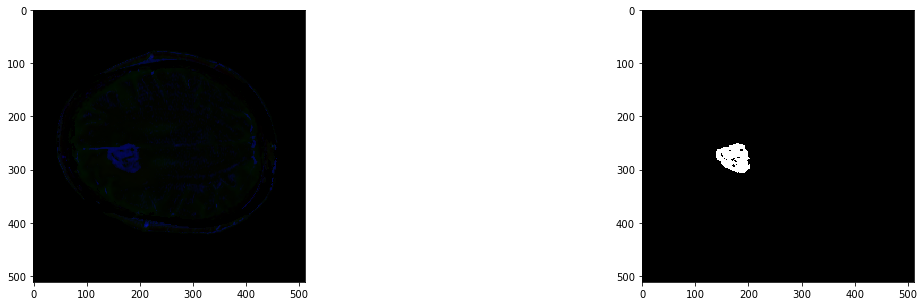

In [2]:
SAMPLE_IMAGE = 'images/PGBM-007_12-29-1992-Mr_Rcbv_Sequence_Fh-74352_15_True.png'
TUMOUR_MASK = 'images/PGBM-007_12-29-1992-Mr_Rcbv_Sequence_Fh-74352_15_True_mask.png'

ori = cv2.imread(SAMPLE_IMAGE, cv2.IMREAD_UNCHANGED)
ori = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
mask = cv2.imread(TUMOUR_MASK)

# plot mask and image
_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(ori)
axes[1].imshow(mask)

(512, 512)


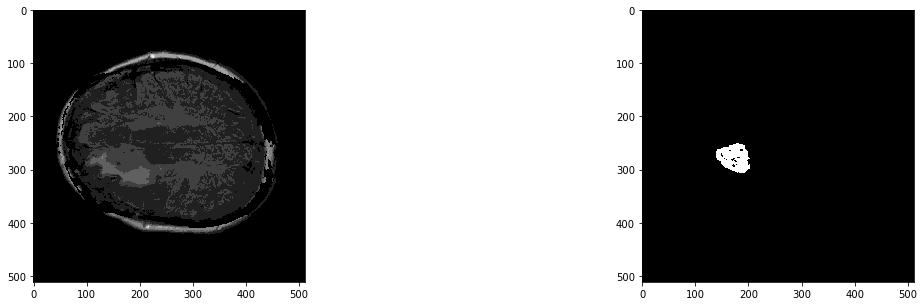

In [3]:
# Show individual channels against mask
_, axes = plt.subplots(1, 2, figsize=(20, 5))
r_ori = x_channel_ex(ori, "r")
print(r_ori.shape)
#r_ori = cv2.cvtColor(r_ori, cv2.COLOR_RGB2GRAY)
axes[0].imshow(r_ori, cmap='gray')
axes[1].imshow(mask)

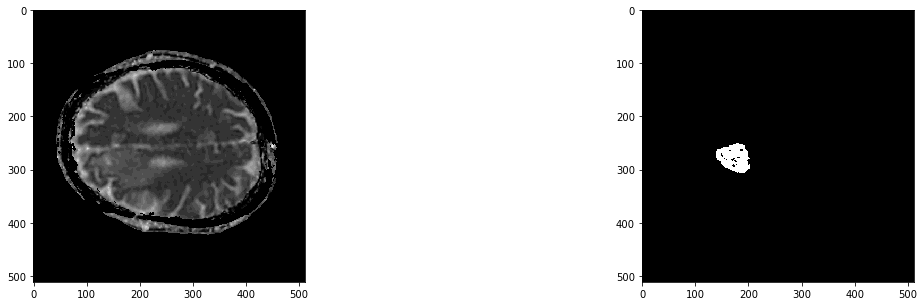

In [4]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
g_ori = x_channel_ex(ori, "g")
#g_ori = cv2.cvtColor(g_ori, cv2.COLOR_RGB2GRAY)
axes[0].imshow(g_ori, cmap='gray')
axes[1].imshow(mask)

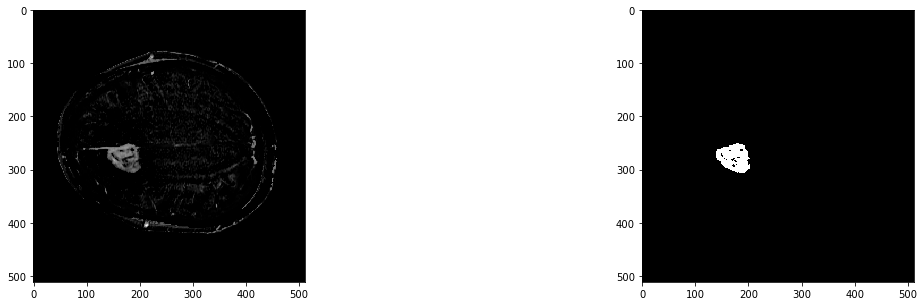

In [5]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
b_ori = x_channel_ex(ori, "b")
#b_ori = cv2.cvtColor(b_ori, cv2.COLOR_RGB2GRAY)
axes[0].imshow(b_ori, cmap='gray')
axes[1].imshow(mask)

In [6]:
# Make super mask
def mask_supersizer(inmask, radius=10):
    supermask = deepcopy(inmask)
    for n1 in range(supermask.shape[0]):
        for n2 in range(supermask.shape[1]):
            # search for masked pixel within radius
            region = inmask[n1-radius:n1+radius, n2-radius:n2+radius]
            if np.any(region>0.5):
                supermask[n1, n2]=0
            else:
                supermask[n1, n2]=1
    return supermask

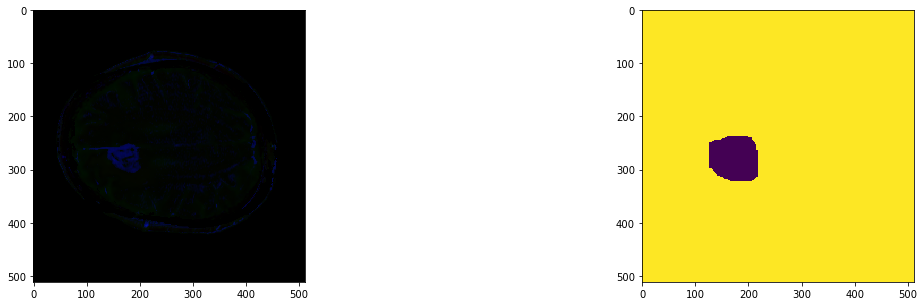

In [7]:
superm = mask_supersizer(mask[:,:,0], radius=15)
# plot mask and image
_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(ori)
axes[1].imshow(superm)

In [8]:
model = PConvUnet(vgg_weights="/DATA/sb/pytorch_to_keras_vgg16.h5", inference_only=True)
model.load("data/logs/brain_tp_dt1_phase3/weights.291-0.22.h5", train_bn=False)

In [9]:
superm3 = np.dstack((superm, superm, superm))

chunker = ImageChunker(512, 512, 0)

ori = ori / 255.

prepro_img = chunker.dimension_preprocess(deepcopy(ori))
prepro_mask = chunker.dimension_preprocess(deepcopy(superm3))
pred = model.predict([prepro_img, prepro_mask])
reconstructed_image = chunker.dimension_postprocess(pred, ori)

In [10]:
print(ori.shape)

(512, 512, 3)


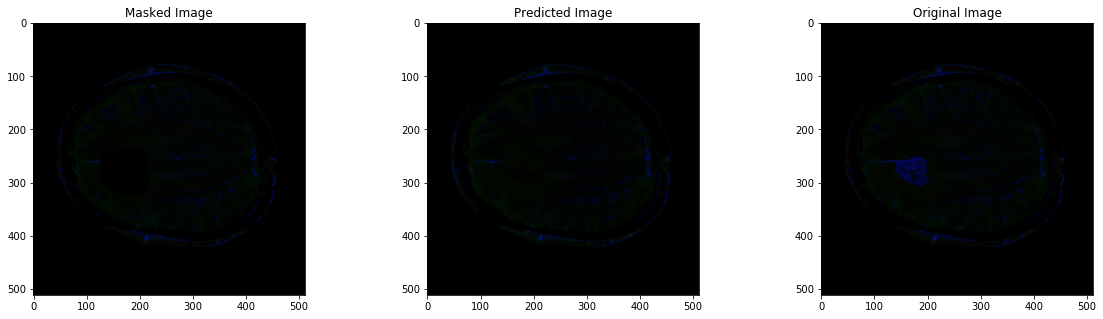

In [11]:
plot_pred(reconstructed_image, superm3, ori)

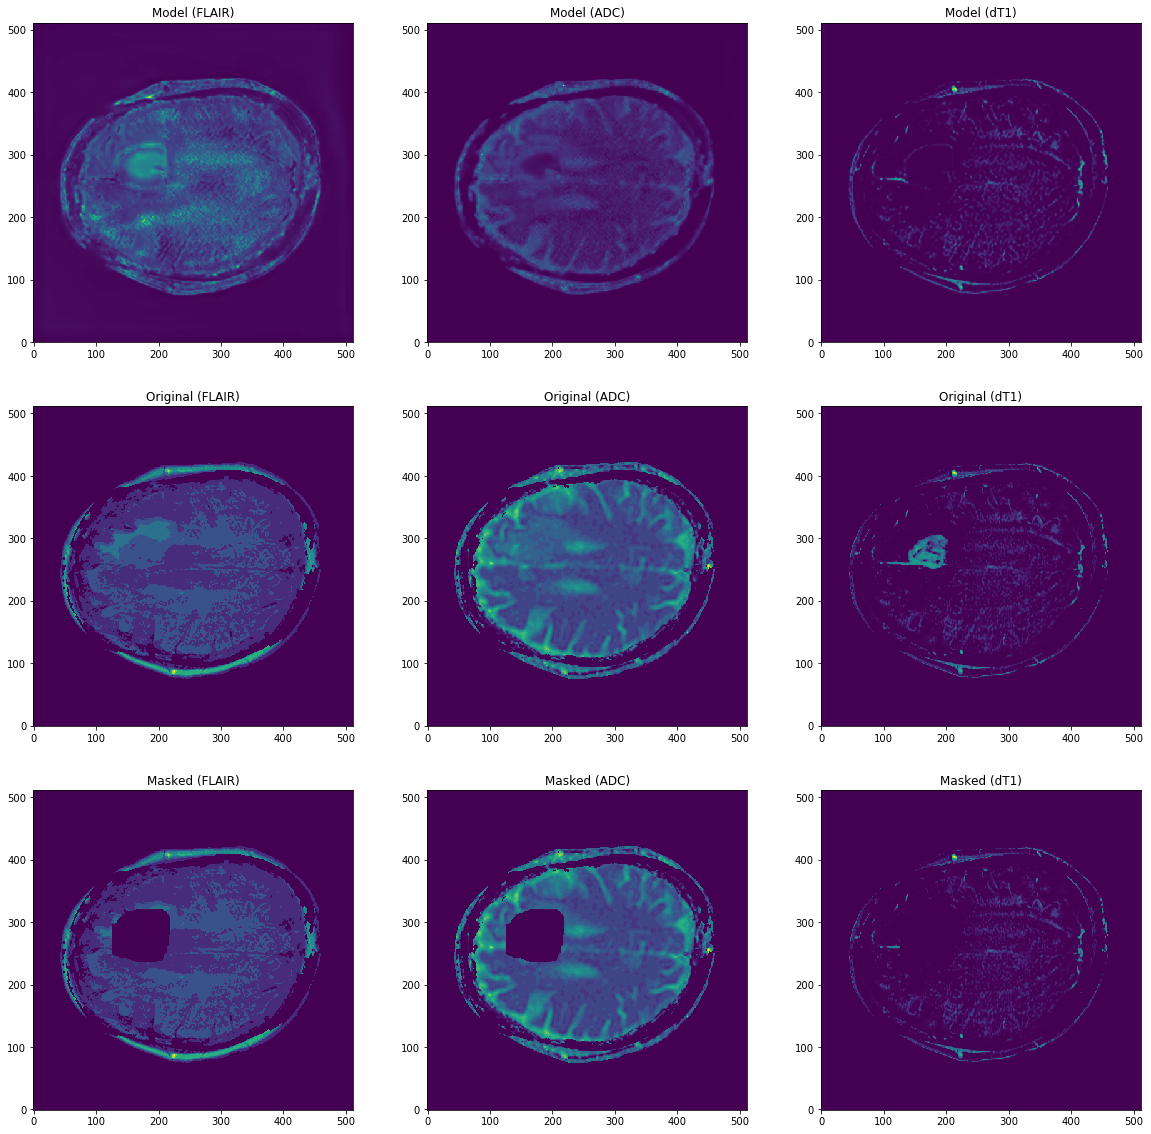

In [12]:
# plot mask and image
_, axes = plt.subplots(3, 3, figsize=(20, 20))
axes[0, 0].imshow(reconstructed_image[:,:,0], origin='lower')
axes[0, 1].imshow(reconstructed_image[:,:,1], origin='lower')
axes[0, 2].imshow(reconstructed_image[:,:,2], origin='lower')
axes[1, 0].imshow((ori)[:,:,0], origin='lower')
axes[1, 1].imshow((ori)[:,:,1], origin='lower')
axes[1, 2].imshow((ori)[:,:,2], origin='lower')
axes[2, 0].imshow((ori*superm3)[:,:,0], origin='lower')
axes[2, 1].imshow((ori*superm3)[:,:,1], origin='lower')
axes[2, 2].imshow((ori*superm3)[:,:,2], origin='lower')
axes[0, 0].set_title("Model (FLAIR)")
axes[0, 1].set_title("Model (ADC)")
axes[0, 2].set_title("Model (dT1)")
axes[1, 0].set_title("Original (FLAIR)")
axes[1, 1].set_title("Original (ADC)")
axes[1, 2].set_title("Original (dT1)")
axes[2, 0].set_title("Masked (FLAIR)")
axes[2, 1].set_title("Masked (ADC)")
axes[2, 2].set_title("Masked (dT1)")
plt.savefig("comparison_tumour.png")

In [14]:
sizex=50
sizey=50

scan=[]
scan0=[]
scan1=[]
ranges=[]
for nx in range(int(512/sizex)+2):
    i_scan = []
    i_scan0 = []
    i_scan1 = []
    i_range = []
    for ny in range(int(512/sizey)+2):
        if nx==0 and ny==0:
            ori_im = ori

        mask_n, xr, yr = RegularMaskGenerator(512, 512, nx*sizex, ny*sizey, sizex, sizey)
        
        r_record = [min(xr), max(xr), min(yr), max(yr)]
        i_range.append(r_record)
        
        prepro_img = chunker.dimension_preprocess(deepcopy(ori))
        prepro_mask = chunker.dimension_preprocess(deepcopy(mask_n))
        pred_n = model.predict([prepro_img, prepro_mask])
        image_n = chunker.dimension_postprocess(pred_n, ori)
        
        diff = image_n[:,:,2]-ori[:,:,2]
        diff = diff[nx*sizex:(nx+1)*sizex, ny*sizey:(ny+1)*sizey]
        resid = np.sum(diff)
        i_scan.append(resid)
        #
        diff0 = image_n[:,:,0]-ori[:,:,0]
        diff0 = diff0[nx*sizex:(nx+1)*sizex, ny*sizey:(ny+1)*sizey]
        resid0 = np.sum(diff0)
        i_scan0.append(resid0)
        #
        diff1 = image_n[:,:,1]-ori[:,:,1]
        diff1 = diff1[nx*sizex:(nx+1)*sizex, ny*sizey:(ny+1)*sizey]
        resid1 = np.sum(diff1)
        i_scan1.append(resid1)
        
    scan.append(i_scan)
    scan0.append(i_scan0)
    scan1.append(i_scan1)
    #
    ranges.append(i_range)

In [15]:
scan = np.array(scan)
scan0 = np.array(scan0)
scan1 = np.array(scan1)

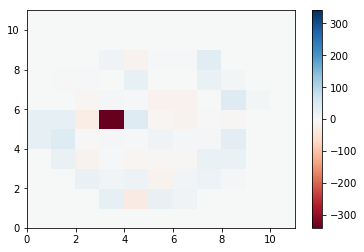

In [16]:
X2, Y2 = np.meshgrid(range(scan.shape[0]), range(scan.shape[1]))
heatmap2d(X2, Y2, scan)

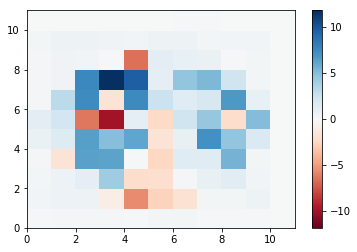

In [17]:
heatmap2d(X2, Y2, scan0, fname="scan_flair.png")

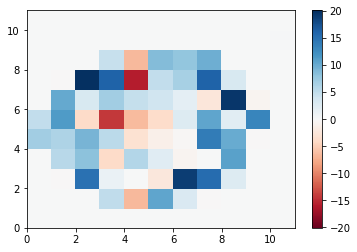

In [18]:
heatmap2d(X2, Y2, scan1, fname="scan_adc.png")

In [19]:
def scan_to_image(_scan, _ranges):
    _img = np.zeros((512, 512))
    for o in range(len(_scan)):
        for i in range(len(_scan[0])):
            _r = _ranges[o][i]
            _img_rep = _img[_r[0]:_r[1]+1, _r[2]:_r[3]+1]
            replval = np.full(_img_rep.shape, _scan[o, i])
            _img[_r[0]:_r[1]+1, _r[2]:_r[3]+1] = replval
    return _img

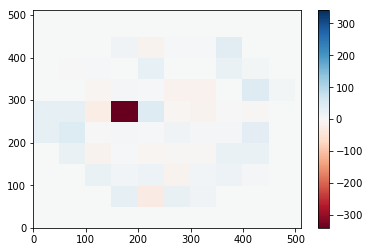

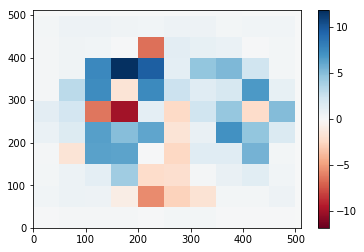

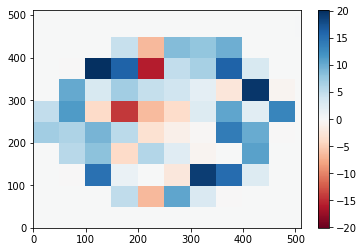

In [20]:
scan_img = scan_to_image(scan, ranges)
scan_img0 = scan_to_image(scan0, ranges)
scan_img1 = scan_to_image(scan1, ranges)
X2_i, Y2_i = np.meshgrid(range(scan_img.shape[0]), range(scan_img.shape[1]))
heatmap2d(X2_i, Y2_i, scan_img, fname="scan_dt1.png")
heatmap2d(X2_i, Y2_i, scan_img0, fname="scan_flair.png")
heatmap2d(X2_i, Y2_i, scan_img1, fname="scan_adc.png")

In [ ]:
def anomaly_type(_img, _tumour, threshold=-1):
    # 0: No anomaly detected (right)
    # 1: No anomaly detected (wrong)
    # 2: Anomaly detected (right)
    # 3: Anomaly detected (wrong)
    new_img = np.zeros((512, 512))
    for i, j in itertools.product(range(_img.shape[0]), range(_img.shape[1])):
        if _img[i, j] < threshold:
            new_img[i, j] = 1.0
    
    overlap = new_img * _tumour
    n_overlap = np.sum(overlap)
    n_new_img = np.sum(new_img)
    n_tumour = np.sum(_tumour)
    
    a_type =0
    if n_tumour:
        # Tumour present
        if n_overlap:
            # detected
            a_type = 2
        else:
            # not detected
            a_type = 1
    else:
        # No Tumour
        if n_new_img:
            # Anomaly found
            a_type = 3
    
    return a_type, n_tumour

def fscan(_image, _sizex=50, _sizey=50):    
    _scan=[]
    _scan0=[]
    _scan1=[]
    _ranges=[]
    for nx in range(int(512/_sizex)+2):
        i_scan = []
        i_scan0 = []
        i_scan1 = []
        i_range = []
        for ny in range(int(512/_sizey)+2):
            #if nx==0 and ny==0:
            #    _image_im = _image

            mask_n, xr, yr = RegularMaskGenerator(512, 512, nx*_sizex, ny*_sizey, _sizex, _sizey)

            r_record = [min(xr), max(xr), min(yr), max(yr)]
            i_range.append(r_record)

            prepro_img = chunker.dimension_preprocess(deepcopy(_image))
            prepro_mask = chunker.dimension_preprocess(deepcopy(mask_n))
            pred_n = model.predict([prepro_img, prepro_mask])
            image_n = chunker.dimension_postprocess(pred_n, _image)

            diff = image_n[:,:,2]-_image[:,:,2]
            resid = np.sum(diff)
            i_scan.append(resid)
            #
            diff0 = image_n[:,:,0]-_image[:,:,0]
            resid0 = np.sum(diff0)
            i_scan0.append(resid0)
            #
            diff1 = image_n[:,:,1]-_image[:,:,1]
            resid1 = np.sum(diff1)
            i_scan1.append(resid1)

        _scan.append(i_scan)
        _scan0.append(i_scan0)
        _scan1.append(i_scan1)
        #
        _ranges.append(i_range)
    return _scan0, _scan1, _scan, _ranges

In [ ]:
print(anomaly_type(scan_img, mask[:,:,0])[0])
print(anomaly_type(scan_img0, mask[:,:,0])[0])
print(anomaly_type(scan_img1, mask[:,:,0])[0])

In [ ]:
def eval_image(_image, _mask, _sizex=50, _sizey=50):
    _image = cv2.imread(_image, cv2.IMREAD_UNCHANGED)
    _image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)
    #
    _image = _image/255
    
    _mask = cv2.imread(_mask)
    _mask = _mask/255
    
    adc_scan, flair_scan, dt1_scan, scan_ranges = fscan(_image, _sizex, _sizey)
    
    dt1_scan = np.array(dt1_scan)
    flair_scan = np.array(flair_scan)
    adc_scan = np.array(adc_scan)
    #
    _scan_img = scan_to_image(dt1_scan, scan_ranges)
    _scan_img0 = scan_to_image(adc_scan, scan_ranges)
    _scan_img1 = scan_to_image(flair_scan, scan_ranges)
    
    a_img, n = anomaly_type(_scan_img, _mask[:,:,0])
    a_img0, n0 = anomaly_type(_scan_img0, _mask[:,:,0])
    a_img1, n1 = anomaly_type(_scan_img1, _mask[:,:,0])
    
    print(_mask.shape)
    return ([a_img, a_img0, a_img1], [n, n0, n1], [_scan_img, _scan_img0, _scan_img1], _image, _mask)

In [ ]:
mask_name = lambda x: x.replace('.png', '_mask.png')

In [ ]:
sample_scores, sample_tumour, sample_scans, sample_i, sample_m = eval_image(SAMPLE_IMAGE, TUMOUR_MASK)
sample_results = dict()
i_sample_dict = dict()
i_sample_dict['scans'] = sample_scans
i_sample_dict['scores'] = sample_scores
i_sample_dict['tumour'] = sample_tumour[0]
i_sample_dict['image'] = sample_i
i_sample_dict['mask'] = sample_m
sample_results["sample"] = i_sample_dict
print(f"Found: {sample_scores}, size: {sample_tumour[0]}")

In [ ]:
scansize = 80

In [ ]:
'''
imgs = os.listdir(base_dir)
masks = [mask_name(x) for x in imgs]
imgs = [os.path.join(base_dir,x) for x in imgs]
masks = [os.path.join(mask_dir,x) for x in masks]

print(f"{len(imgs)} images to process")
results = dict()
for i, m in zip(imgs, masks):
    i_results = dict()
    print(f"Processing image: {i}")
    print(f"Processing mask: {m}")
    print(f"Check: {os.path.exists(i)}, {os.path.exists(m)}")
    l_scores, l_tumour, l_scans, _im, _m = eval_image(i, m, scansize, scansize)
    print(f"Found: {l_scores}, size: {l_tumour[0]}")
    i_results["scores"] = l_scores
    i_results["tumour"] = l_tumour[0]
    i_results["scans"] = l_scans
    i_results["image"] = _im
    i_results["mask"] = _m
    results[i] = i_results

with open('res_%s.pkl' % scansize, 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

In [ ]:
#plotScans(results, "images/Brain-Tumor-Progression_flattened_tumour_alt3/PGBM-002_08-13-1996-Mr_Rcbv_Sequence-46313_13_True.png")

In [ ]:
plotScans(sample_results,"sample")

In [ ]:
def combRes(files_scans, detval=2):
    # Files must have the same keys
    detected = dict()
    for f in files_scans:
        _res = pickle.load(open(f, 'rb'))
        for i, entry in _res.items():
            _scores = entry['scores']
            try:
                val = detected[i]
            except KeyError:
                detected[i] = 0
            
            if _scores[0]==detval:
                detected[i] = 1
    return detected

In [ ]:
res_dict = combRes(['res_50.pkl', 'res_80.pkl'])

In [ ]:
arr_res = np.array(list(res_dict.values()))

In [ ]:
unique_elements, counts_elements = np.unique(arr_res, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
'''
test_dir = 'images/test'
imgs_test = os.listdir(test_dir)
masks_test = [mask_name(x) for x in imgs_test]
imgs_test = [os.path.join(test_dir,x) for x in imgs_test]
masks_test = [os.path.join(mask_dir,x) for x in masks_test]

print(f"{len(imgs_test)} images to process")
results_test = dict()
for i, m in zip(imgs_test, masks_test):
    i_results = dict()
    print(f"Processing image: {i}")
    print(f"Processing mask: {m}")
    print(f"Check: {os.path.exists(i)}, {os.path.exists(m)}")
    l_scores, l_tumour, l_scans, _im, _m = eval_image(i, m, scansize, scansize)
    print(f"Found: {l_scores}, size: {l_tumour[0]}")
    i_results["scores"] = l_scores
    i_results["tumour"] = l_tumour[0]
    i_results["scans"] = l_scans
    i_results["image"] = _im
    i_results["mask"] = _m
    results_test[i] = i_results

with open('res_%s_test.pkl' % scansize, 'wb') as fp:
    pickle.dump(results_test, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

In [ ]:
res_dict_test = combRes(['res_50_test.pkl', 'res_80_test.pkl'], detval=3)
arr_res_test = np.array(list(res_dict_test.values()))
unique_elements_test, counts_elements_test = np.unique(arr_res_test, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements_test, counts_elements_test)))

In [ ]:
# Fig for paper
# plot mask and image
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].imshow((ori)[:,:,0], origin='lower')
axes[0, 1].imshow((ori)[:,:,1], origin='lower')
axes[1, 0].imshow((ori)[:,:,2], origin='lower')
axes[1, 1].imshow(mask, origin='lower')
plt.savefig("example.png")

In [ ]:
mask_gen = MaskGenerator(512, 512, rand_seed=42)
mask_1 = mask_gen._generate_mask()
mask_2 = mask_gen._generate_mask()
mask_3 = mask_gen._generate_mask()

In [ ]:
# Fig for paper
# plot mask and image
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow((ori*mask_1)[:,:,0], origin='lower')
axes[1].imshow((ori*mask_2)[:,:,0], origin='lower')
axes[2].imshow((ori*mask_3)[:,:,0], origin='lower')
plt.savefig("masks.png")